In [1]:
from utils import *
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import random
import warnings
import time
warnings.filterwarnings('ignore')

In [2]:
%store -r data
%store -r target

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(target)

In [4]:
data = standardize(data)
X_dev, y_dev, X_test, y_test, X_train, y_train, X_val, y_val = split(data,label)

X_train shape: (810, 54)
X_test shape: (100, 54)
X_val shape: (90, 54)
y_train shape: (810,)
y_test shape: (100,)
y_val shape: (90,)


### Original Model
Building a model with no parameter tuning and using the raw csv file

In [5]:
xgb_start_time = time.monotonic()
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_dev, y_dev)
xgb_end_time = time.monotonic()

predsDevxgb = model_xgb.predict(X_dev)
predsTestxgb = model_xgb.predict(X_test)

In [6]:
testxgb_score =  accuracy_score(y_test, predsTestxgb)
devxgb_score = accuracy_score(y_dev, predsDevxgb)

In [7]:
print("Classification Score for XGB Classifier on Dev dataset:\n")
print("Dev Score : ", devxgb_score)
print(classification_report(y_dev, predsDevxgb))
print("--------------------------------------------------------")
print("Classification Score for XGB Classifier on Test dataset:\n")
print("Test Score :", testxgb_score)
print(classification_report(y_test, predsTestxgb))

Classification Score for XGB Classifier on Dev dataset:

Dev Score :  0.9988888888888889
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        92
           1       1.00      1.00      1.00        92
           2       1.00      1.00      1.00        92
           3       1.00      1.00      1.00        92
           4       1.00      1.00      1.00        93
           5       1.00      1.00      1.00        83
           6       0.99      1.00      0.99        92
           7       1.00      1.00      1.00        92
           8       1.00      1.00      1.00        86
           9       1.00      0.99      0.99        86

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900

--------------------------------------------------------
Classification Score for XGB Classifier on Test dataset:

Test Score : 0.79
              preci

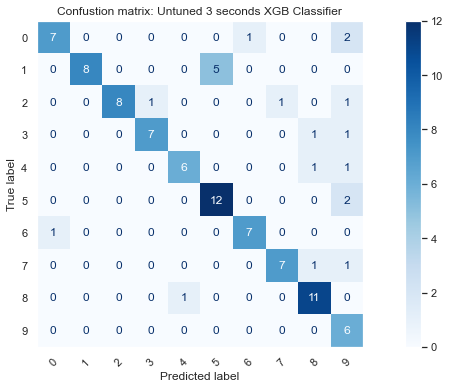

Accuracy : 0.79
Macro F-1 Score : 0.79


In [8]:
# Evaluate Model on Test set
class_labels = list(model_xgb.classes_)
macro_f1, accuracy = evaluate_model(predsTestxgb, y_test, class_labels,
                                    'Confustion matrix: Untuned 3 seconds XGB Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the raw csv file

In [9]:
parameters = {"n_estimators": np.linspace(5,100,3,dtype=int),
             "learning_rate": [0.1,0.001,0.01],
             "max_depth": random.sample(range(3, 30),3)}
print(parameters)

{'n_estimators': array([  5,  52, 100]), 'learning_rate': [0.1, 0.001, 0.01], 'max_depth': [16, 13, 6]}


In [10]:
tune_xgb = GridSearchCV(estimator = model_xgb, param_grid = parameters, cv = 5)
tune_xgb.fit(X_dev, y_dev)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_cat_to_onehot=4, max_delta_step=0,
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                   

In [11]:
print("Best Score :", tune_xgb.best_score_)
print("Best Parameters :",tune_xgb.best_params_)

Best Score : 0.7033333333333334
Best Parameters : {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}


In [12]:
predsDevxgb_tuned = tune_xgb.predict(X_dev)
predsTestxgb_tuned = tune_xgb.predict(X_test)

print("Score on Dev data for xgb using GridSearchCV:", accuracy_score(y_dev, predsDevxgb_tuned))
print("Score on Test data for xgb using GridSearchCV:",accuracy_score(y_test, predsTestxgb_tuned))

Score on Dev data for xgb using GridSearchCV: 0.9988888888888889
Score on Test data for xgb using GridSearchCV: 0.78


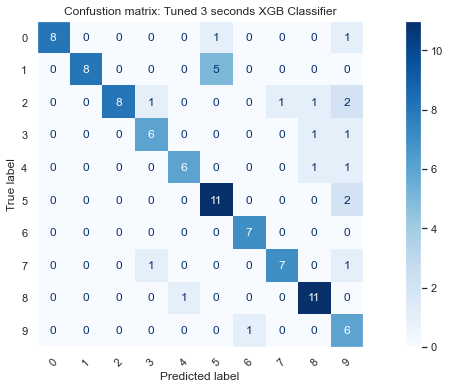

Accuracy : 0.78
Macro F-1 Score : 0.79


In [13]:
# Evaluate Model on Test set
class_labels = list(model_xgb.classes_)
macro_f1, accuracy = evaluate_model(predsTestxgb_tuned, y_test, class_labels,
                                    'Confustion matrix: Tuned 3 seconds XGB Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Dimensionality reduction of data using PCA

In [14]:
# Principal Component Analysis 
### cite : https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/

# create the PCA instance
pca = PCA(n_components=30)
# fit on data
pca_data = pca.fit_transform(X_dev)
pca_data_test = pca.transform(X_test)
# pca_data_dev = pca.transform(X_dev)
PCA_df= pd.DataFrame(data=pca_data)
y_dev = pd.DataFrame(y_dev)
y_dev.index = PCA_df.index
pca_final=pd.concat([PCA_df,y_dev], axis = 1)
# access values
print("Explained Variance of each component:",pca.explained_variance_)
print("Sum of Explained Variance:", sum(pca.explained_variance_ratio_))

Explained Variance of each component: [0.27462107 0.16378828 0.106374   0.0723295  0.05484226 0.0387792
 0.02690359 0.02395643 0.02175637 0.01846612 0.01427943 0.01395746
 0.0120279  0.01112263 0.01017837 0.00968102 0.00884281 0.00796856
 0.00769711 0.00724496 0.00710396 0.00655197 0.0060014  0.0056883
 0.00541317 0.00495627 0.00484587 0.00468839 0.00450244 0.00421334]
Sum of Explained Variance: 0.9526339024319308


In [15]:
pca_final.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,0
0,0.000578,-0.630373,-0.054837,0.410234,0.009388,0.027373,-0.032695,-0.147324,0.031383,0.111815,...,0.075295,0.101904,-0.079630,0.038325,-0.005625,-0.023161,0.123573,0.050644,0.040440,1
1,0.071451,-0.402465,-0.106785,0.332658,-0.060422,0.226589,0.122804,-0.066845,0.069261,-0.088956,...,0.119867,0.093887,-0.016989,0.094375,0.005932,-0.109091,-0.027823,-0.005325,-0.000637,5
2,-0.047268,0.326820,-0.598692,0.227380,0.045610,0.264122,-0.077907,0.063582,-0.168402,0.038901,...,-0.088282,0.044337,-0.057231,-0.028725,0.014260,0.089124,-0.017704,0.155972,-0.052945,2
3,-0.437642,0.235405,-0.003960,0.029110,-0.170677,-0.094826,-0.142893,0.105725,0.099782,-0.181444,...,0.021662,-0.012732,0.027941,0.054251,0.133389,0.101558,0.085626,0.037053,0.063623,6
4,-0.849344,0.103658,-0.048105,-0.018132,-0.023246,-0.159359,0.035769,-0.071887,0.111837,0.102878,...,0.040284,-0.009411,0.015145,-0.028521,0.035643,0.010332,-0.039741,-0.011455,0.027968,3


### PCA - Original Model
Building a model with no parameter tuning and using the PCA data

In [17]:
model_pca = xgb.XGBClassifier()
model_pca.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainxgb = model_pca.predict(pca_data)
pcaTestxgb = model_pca.predict(pca_data_test)

In [18]:
pcatestxgb_score =  accuracy_score(y_test, pcaTestxgb)
pcaxgb_score = accuracy_score(y_dev, pcaTrainxgb)

In [19]:
print("Classification Score for XGB Classifier on Train dataset:\n")
print("Train Score : ", pcaxgb_score)
print("--------------------------------------------------------")
print("Classification Score for XGB Classifier on Test dataset:\n")
print("Test Score :", pcatestxgb_score)

Classification Score for XGB Classifier on Train dataset:

Train Score :  0.9988888888888889
--------------------------------------------------------
Classification Score for XGB Classifier on Test dataset:

Test Score : 0.7


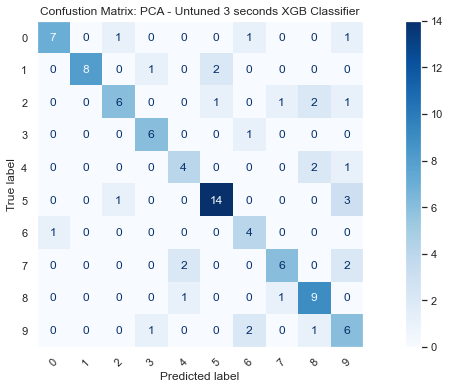

Accuracy : 0.70
Macro F-1 Score : 0.69


In [20]:
# Evaluate Model
class_labels = list(model_xgb.classes_)
macro_f1, accuracy = evaluate_model(pcaTestxgb, y_test, class_labels,
                                    'Confustion Matrix: PCA - Untuned 3 seconds XGB Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### PCA - Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the PCA data

In [21]:
pca_final.iloc[:,:30]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.000578,-0.630373,-0.054837,0.410234,0.009388,0.027373,-0.032695,-0.147324,0.031383,0.111815,...,-0.184972,0.075295,0.101904,-0.079630,0.038325,-0.005625,-0.023161,0.123573,0.050644,0.040440
1,0.071451,-0.402465,-0.106785,0.332658,-0.060422,0.226589,0.122804,-0.066845,0.069261,-0.088956,...,0.120254,0.119867,0.093887,-0.016989,0.094375,0.005932,-0.109091,-0.027823,-0.005325,-0.000637
2,-0.047268,0.326820,-0.598692,0.227380,0.045610,0.264122,-0.077907,0.063582,-0.168402,0.038901,...,-0.009466,-0.088282,0.044337,-0.057231,-0.028725,0.014260,0.089124,-0.017704,0.155972,-0.052945
3,-0.437642,0.235405,-0.003960,0.029110,-0.170677,-0.094826,-0.142893,0.105725,0.099782,-0.181444,...,-0.128302,0.021662,-0.012732,0.027941,0.054251,0.133389,0.101558,0.085626,0.037053,0.063623
4,-0.849344,0.103658,-0.048105,-0.018132,-0.023246,-0.159359,0.035769,-0.071887,0.111837,0.102878,...,-0.060426,0.040284,-0.009411,0.015145,-0.028521,0.035643,0.010332,-0.039741,-0.011455,0.027968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,-0.654431,0.218151,0.332880,0.090825,0.133881,-0.215551,0.054108,0.024745,0.233059,-0.024797,...,0.275546,-0.019639,0.087913,-0.033654,-0.051491,-0.004113,-0.085775,-0.009351,0.001644,0.009984
896,0.515280,-0.634698,0.082394,0.485203,-0.101831,-0.139826,-0.145431,0.177575,0.022340,0.179411,...,0.033668,-0.014332,-0.008044,-0.115285,-0.062241,-0.186112,-0.010565,-0.001451,-0.046455,-0.043470
897,0.976786,0.902560,0.595924,0.289104,0.483065,0.202643,0.115369,0.003243,-0.108632,-0.320623,...,0.043810,0.006368,-0.010530,-0.013404,-0.031235,-0.125648,-0.037582,0.001719,0.072139,0.048700
898,0.124804,0.297352,-0.452053,-0.032074,0.037626,0.157138,-0.016185,-0.012221,-0.084171,0.132887,...,0.118379,-0.044831,0.004093,0.034133,0.039145,-0.124853,0.085674,0.039134,0.034006,-0.082801


In [22]:
model_pca_tuned = tune_xgb
model_pca_tuned.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainxgb_tuned = model_pca_tuned.predict(pca_data)
pcaTestxgb_tuned = model_pca_tuned.predict(pca_data_test)

In [23]:
pcatestxgb_score =  accuracy_score(y_test, pcaTestxgb_tuned)
pcaxgb_score = accuracy_score(y_dev, pcaTrainxgb_tuned)

In [24]:
print("Classification Score for XGB Classifier on Train dataset:\n")
print("Train Score : ", pcaxgb_score)
print("--------------------------------------------------------")
print("Classification Score for XGB Classifier on Test dataset:\n")
print("Test Score :", pcatestxgb_score)

Classification Score for XGB Classifier on Train dataset:

Train Score :  0.9988888888888889
--------------------------------------------------------
Classification Score for XGB Classifier on Test dataset:

Test Score : 0.65


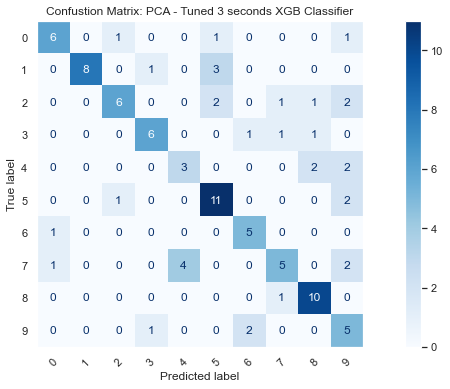

Accuracy : 0.65
Macro F-1 Score : 0.64


In [26]:
# Evaluate Model
class_labels = list(model_xgb.classes_)
macro_f1, accuracy = evaluate_model(pcaTestxgb_tuned, y_test, class_labels,
                                    'Confustion Matrix: PCA - Tuned 3 seconds XGB Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)